# Fatal Encounter Supporting Links

This notebook uses the log file of the named entity recognition notebook to see what URLs are no longer available on the web and if they have been archived at the Internet Archive.

In [2]:
import re
import time
import wayback
import pandas as pd

It is helpful to have the Fatal Encounter spreadsheet, to get a sense of the complete set of URLs.

In [3]:
sheet_id = "1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE"
sheet_name = "sample_1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df_fe = pd.read_csv(url)
df_fe

Unique ID                                        Name   Age  Gender  \
0        31495.0                            Ashley McClendon  28.0  Female   
1        31496.0                     Name withheld by police   NaN  Female   
2        31497.0                     Name withheld by police   NaN    Male   
3        31491.0                        Johnny C. Martin Jr.  36.0    Male   
4        31492.0                               Dennis McHugh  44.0    Male   
...          ...                                         ...   ...     ...   
31493    25746.0                             Samuel H. Knapp   NaN    Male   
31494    25747.0                              Mark A. Horton   NaN    Male   
31495    25748.0                       Phillip A. Blurbridge   NaN    Male   
31496    25749.0                                  Mark Ortiz   NaN    Male   
31497        NaN  This is a spacer for Fatal Encounters use.   NaN     NaN   

                          Race    Race with imputations  \
0       African-American/Black   African-American/Black   
1             Race unspecified                      NaN   
2             Race unspecified                      NaN   
3             Race unspecified                      NaN   
4      European-American/White                      NaN   
...                        ...                      ...   
31493  European-American/White  European-American/White   
31494   African-American/Black   African-American/Black   
31495   African-American/Black   African-American/Black   
31496          Hispanic/Latino          Hispanic/Latino   
31497                      NaN                      NaN   

      Imputation probability  \
0                Not imputed   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   
...                      ...   
31493            Not imputed   
31494            Not imputed   
31495            Not imputed   
31496            Not imputed   
31497                    NaN   

                          URL of image (PLS NO HOTLINKS)  \
0      https://fatalencounters.org/wp-content/uploads...   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4                                                    NaN   
...                                                  ...   
31493                                                NaN   
31494                                                NaN   
31495                                                NaN   
31496                                                NaN   
31497                                                NaN   

       Date of injury resulting in death (month/day/year)  \
0                                             12/31/2021    
1                                             12/31/2021    
2                                             12/31/2021    
3                                             12/30/2021    
4                                             12/30/2021    
...                                                  ...    
31493                                         01/01/2000    
31494                                         01/01/2000    
31495                                         01/01/2000    
31496                                         01/01/2000    
31497                                         12/31/1999    

                         Location of injury (address)  ... URL Temp  \
0                    South Pearl Street and Tory Road  ...      NaN   
1                                    1500 21st Street  ...      NaN   
2                                    1500 21st Street  ...      NaN   
3                                       Martinez Lane  ...      NaN   
4                                    435 E 4th Street  ...      NaN   
...                                               ...  ...      ...   
31493                    

The *fe-links.log* file contains error messages when the Fatal Encounters Named Entity Recognition analysis was unable to download the supporting link URL because it was no longer on the web. The messages look like:

```
ERROR:root:caught article error: Article `download()` failed with 404 Client Error: Not Found for url: https://www.atlantanewsfirst.com/news/update-man-accused-of-killing-clayton-county-officer-2-women-identified/article_4281c0f6-5253-11ec-9092-afa2216f0221.html on URL https://www.cbs46.com/news/update-man-accused-of-killing-clayton-county-officer-2-women-identified/article_4281c0f6-5253-11ec-9092-afa2216f0221.html
```

Instead of rechecking all the URLs we can use this logs to generate a list of URLs that are *404 Not Found*.

In [10]:
urls = []

for line in open('fe-links.log'):
    if m := re.search(r'failed with 404 Client Error: .* on URL (.*)', line):
        urls.append(m.group(1))

len(urls)

3085

In [11]:
len(urls) / len(df_fe)

0.09794272652231888

So about 10% of the links are no longer available. This highlights the need to archive content when it is being used as evidence.

## Wayback Machine

The Internet Archive's Wayback Machine archives regions of the web. The web is a big place that is constantly changing, so it's impossible for them to archive everything. But it would be interesting to see how many of these URLs have been archived. The Python [wayback](https://wayback.readthedocs.io/en/stable/) client lets you query the Wayback Machine API.

Since there can be multiple snapshots of a given URL it's important to step through all the results and see if there is one that is a *200 OK* response, which indicates that the Wayback Machine was able to archive a snapshot of the URL that returned properly (not a redirect, or not found message, which Wayback Machine stores as well).

In [12]:
session = wayback.WaybackSession(retries=25)
wb = wayback.WaybackClient(session)

def archived_page(url):
    time.sleep(.5)
    try:
        for result in wb.search(url):
            if result.status_code == 200:
                return result.view_url
    except wayback.exceptions.BlockedSiteError:
        return None

archived_page(urls[0])

'https://web.archive.org/web/20211231164215/https://www.thelancasternews.com/content/21-year-old-man-killed-when-car-fleeing-police-crashes'

Now we can look up all the urls to see if they are there. First it's helpful to have the URLs in a DataFrame to keep the URL and its archive URL together:

In [13]:
urls = pd.DataFrame({"url": urls})
urls

url
0     https://www.thelancasternews.com/content/21-ye...
1     https://www.wrcbtv.com/story/45482651/authorit...
2     https://www.wrcbtv.com/story/45482651/authorit...
3     https://www.cbs46.com/news/update-man-accused-...
4     https://www.cbs46.com/news/police-man-shoots-h...
...                                                 ...
3080  http://www.foxnews.com/story/2007/06/15/man-ki...
3081  http://www.foxnews.com/story/2007/06/15/man-ki...
3082  http://www.foxnews.com/story/2007/06/15/man-ki...
3083  http://jacksonville.com/content/jacksonville-a...
3084  http://cjonline.com/stories/061307/loc_1765952...

[3085 rows x 1 columns]

Now we can apply the *archived_page()* function to create a new column in our DataFrame named *archive*.

In [14]:
urls['archive'] = urls.url.apply(archived_page)
urls

url  \
0     https://www.thelancasternews.com/content/21-ye...   
1     https://www.wrcbtv.com/story/45482651/authorit...   
2     https://www.wrcbtv.com/story/45482651/authorit...   
3     https://www.cbs46.com/news/update-man-accused-...   
4     https://www.cbs46.com/news/police-man-shoots-h...   
...                                                 ...   
3080  http://www.foxnews.com/story/2007/06/15/man-ki...   
3081  http://www.foxnews.com/story/2007/06/15/man-ki...   
3082  http://www.foxnews.com/story/2007/06/15/man-ki...   
3083  http://jacksonville.com/content/jacksonville-a...   
3084  http://cjonline.com/stories/061307/loc_1765952...   

                                                archive  
0     https://web.archive.org/web/20211231164215/htt...  
1     https://web.archive.org/web/20211218032210/htt...  
2     https://web.archive.org/web/20211218032210/htt...  
3     https://web.archive.org/web/20211202030610/htt...  
4     https://web.archive.org/web/20211108005832/htt...  
...                                                 ...  
3080                                               None  
3081                                               None  
3082                                               None  
3083  https://web.archive.org/web/20150201142052/htt...  
3084                                               None  

[3085 rows x 2 columns]

In [35]:
urls[urls.archive.isna()]

url archive
12    https://www.gallatinnews.com/news/police-2-dea...    None
15    https://illinoisnewstoday.com/two-people-kille...    None
16    https://illinoisnewstoday.com/two-people-kille...    None
17    https://www.heraldstandard.com/news/state/arka...    None
18    https://www.wcsmradio.com/index.php/news/63569...    None
...                                                 ...     ...
3078        http://www.wktv.com/news/local/8060547.html    None
3080  http://www.foxnews.com/story/2007/06/15/man-ki...    None
3081  http://www.foxnews.com/story/2007/06/15/man-ki...    None
3082  http://www.foxnews.com/story/2007/06/15/man-ki...    None
3084  http://cjonline.com/stories/061307/loc_1765952...    None

[1233 rows x 2 columns]

In [15]:
len(urls[urls.archive.isna()]) / len(urls)

0.39967585089141006

So 1,233 (40%) of these URLs were not archived by the Internet Archive's Wayback Machine. They are effectively gone, unless the content has moved elsewhere, or someone else has archived them.

In [16]:
urls.to_csv('data/urls-missing.csv', index=False)

## Archive Quality

On close inspection it's clear that not all the archived pages are complete for example the video for this page has not been preserved by the Internet Archive:

https://web.archive.org/web/20230521221951/https://www.wbtv.com/2021/12/23/police-man-forced-woman-into-car-fired-shots-officers-during-east-charlotte-chase/

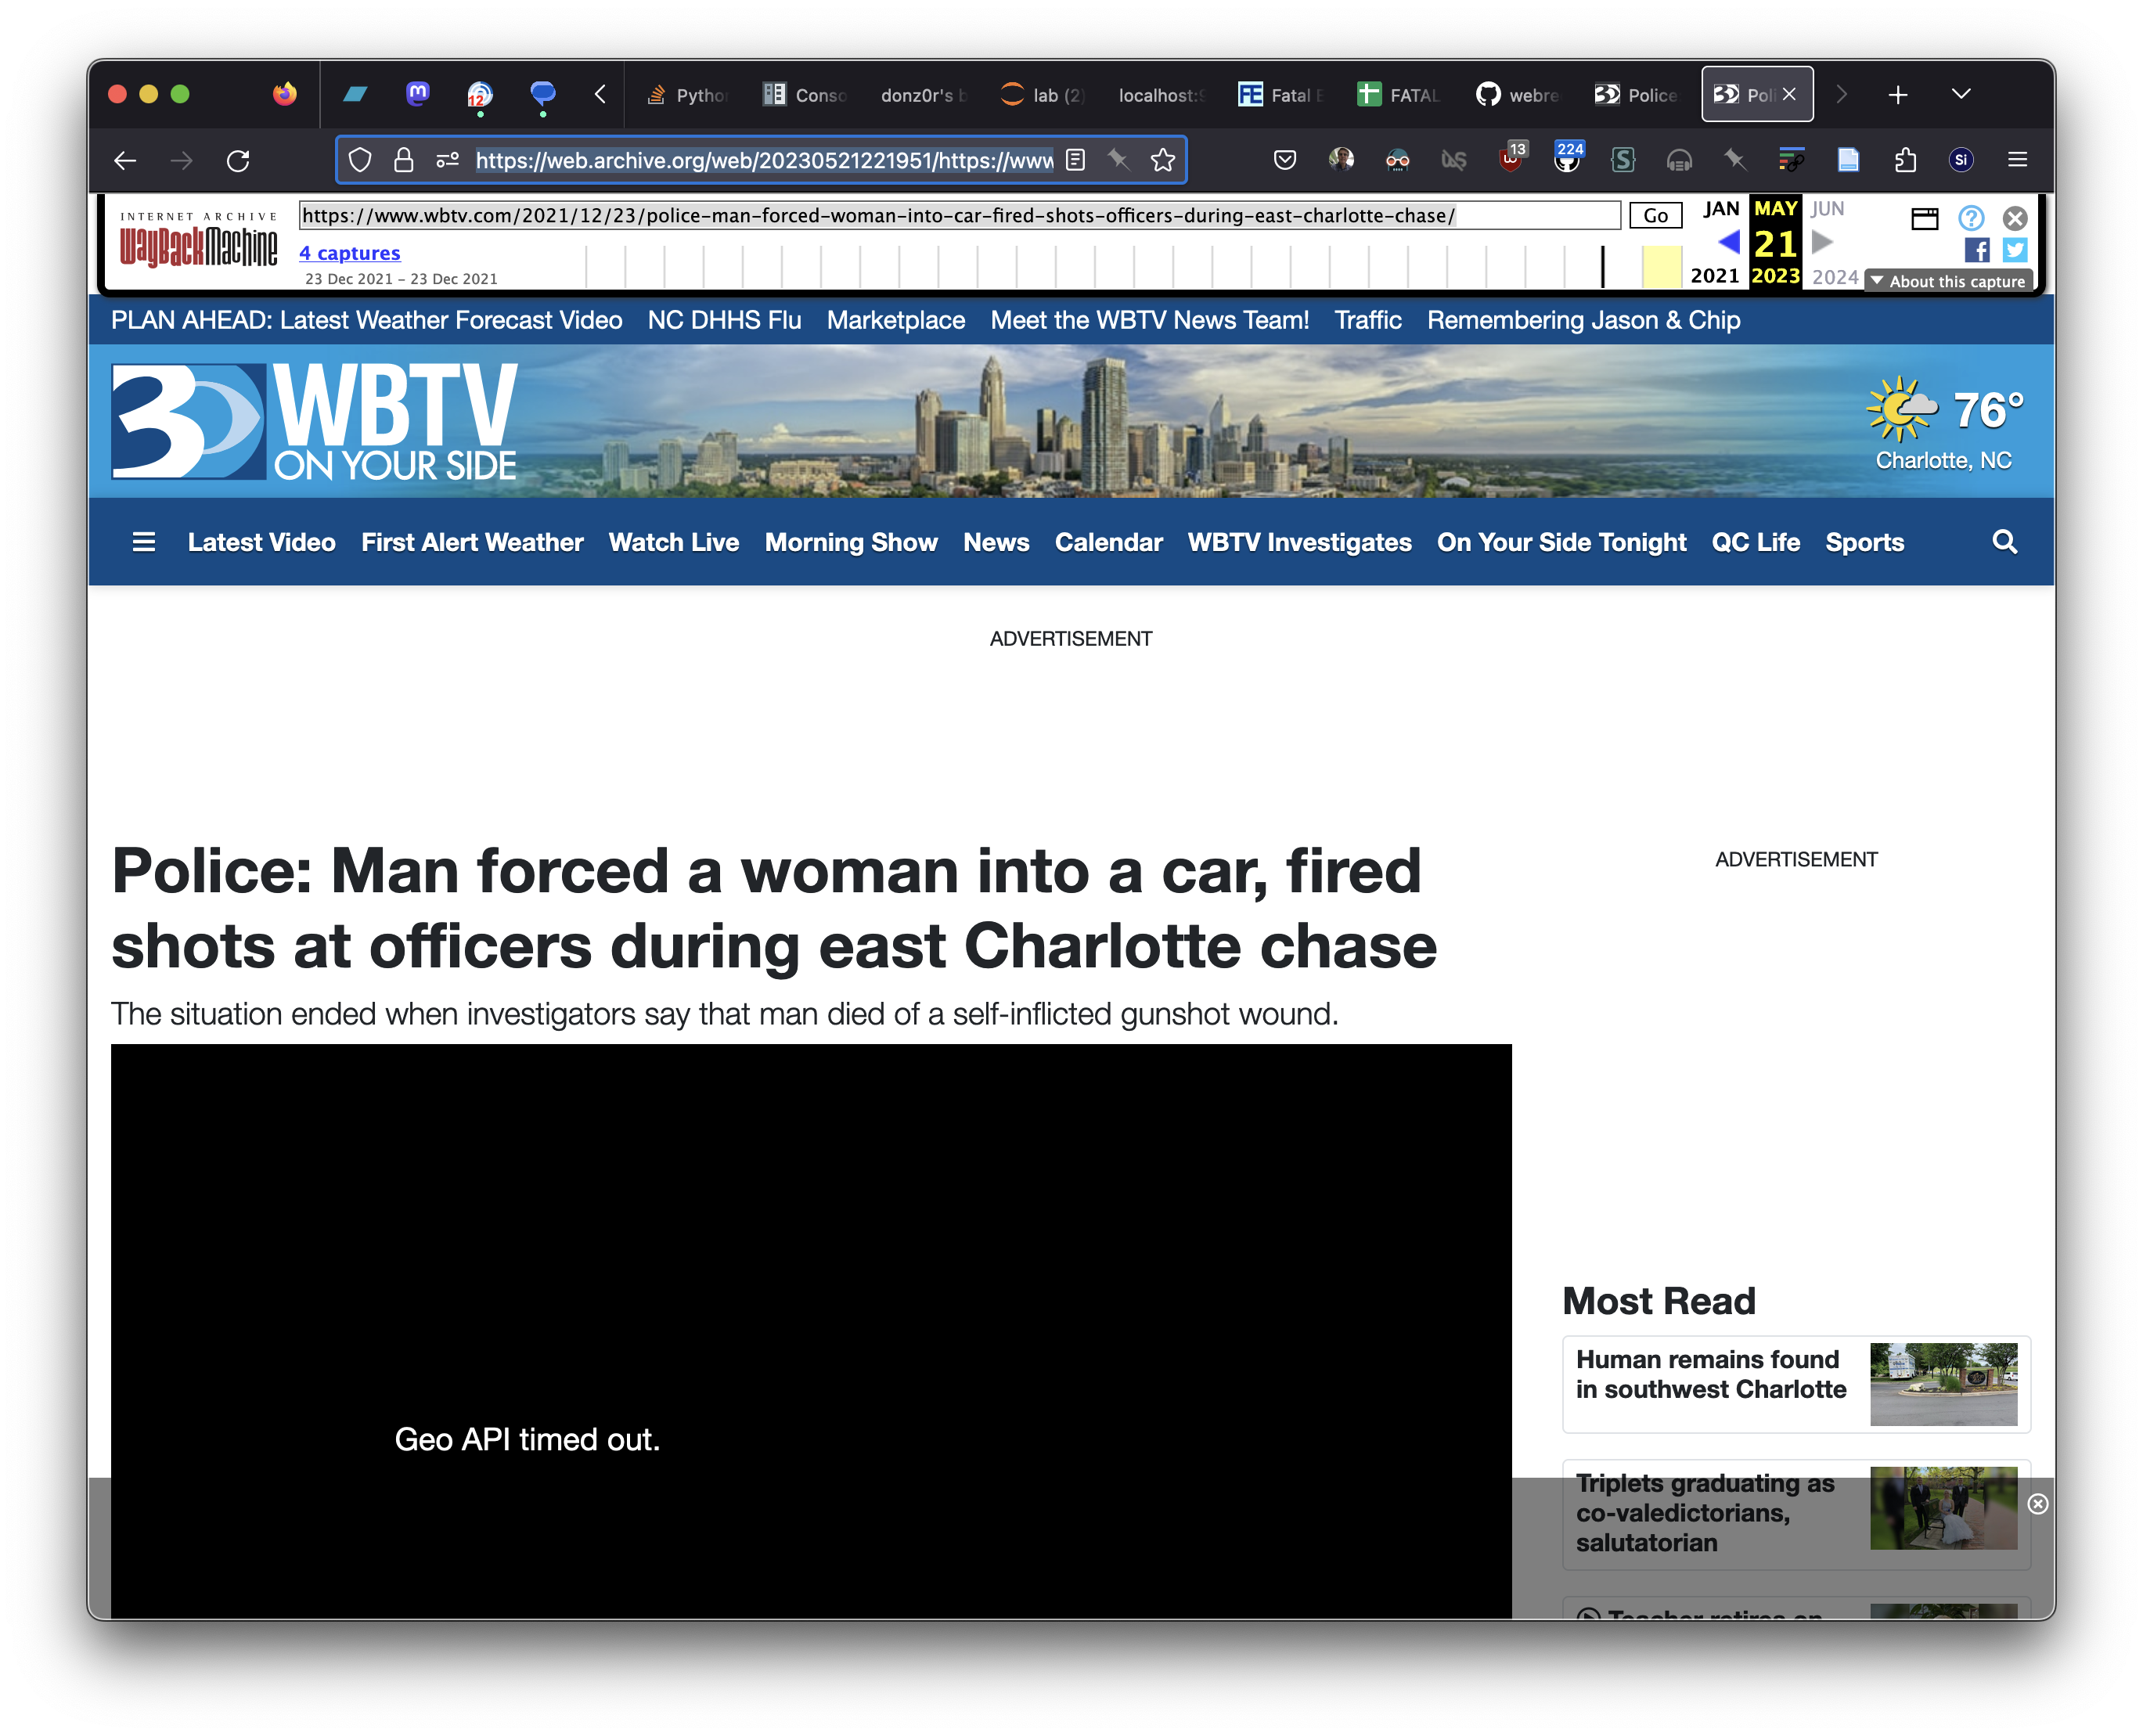

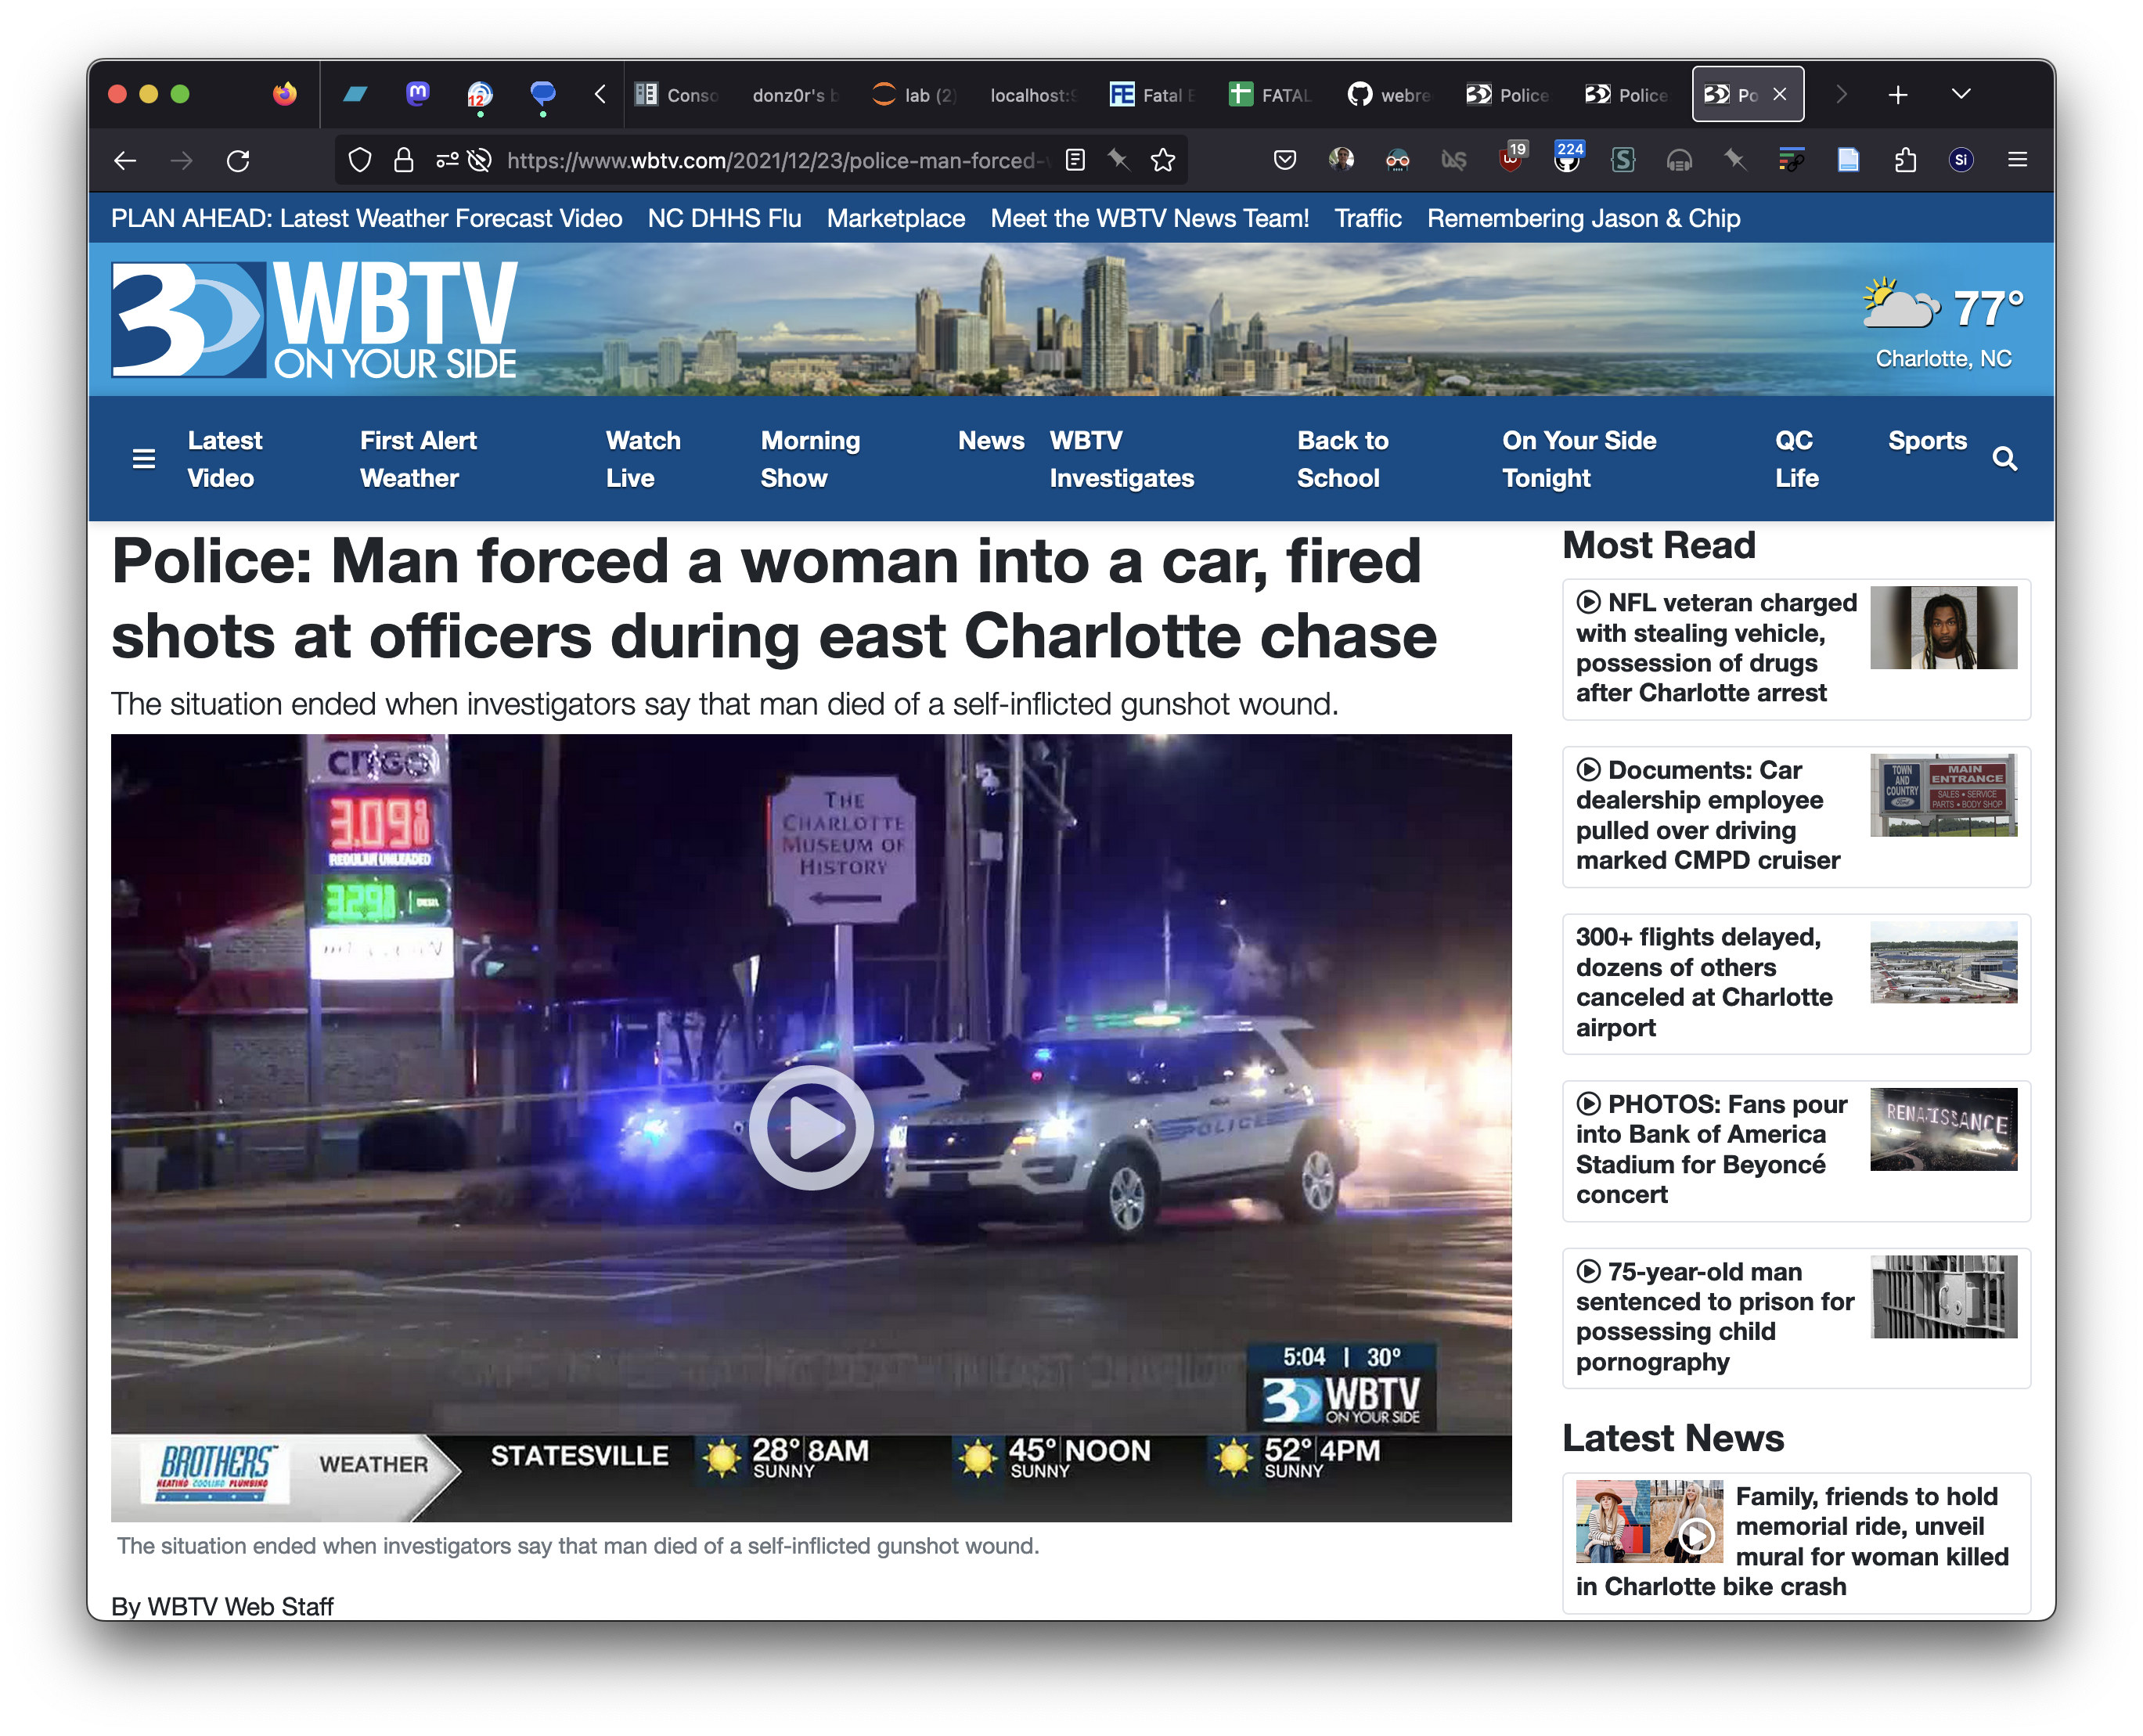

In [38]:
from IPython.display import Image, display
display(Image(filename='images/video1.png', embed=True))
display(Image(filename='images/video2.png', embed=True))

## Seed List

To ensure that the remaining good links continue to work in the future we can archive the existing links by writing them out as a seed list and using [browsertrix-crawler](https://github.com/webrecorder/browsertrix-crawler) to archive them.

browsertrix-crawler lets you write a crawl configuration as a YAML file, and then run it with a docker container. First lets start the YAML file and write the URLs we want to archive to it.

In [33]:
config = """\
collection: fatal-encounters
generateWACZ: true
workers: 4
screencastPort: 9037
seeds:
  - url: https://fatalencounters.org/
    scopeType: prefix
"""

In [34]:
for url in df_fe['Supporting document link'].unique():
    if pd.notna(url) and url.startswith('http'):
        config += f"  - url: {url}\n    scopeType: page\n"

print(config[0:5000])

collection: fatal-encounters
generateWACZ: true
workers: 4
screencastPort: 9037
seeds:
  - url: https://fatalencounters.org/
    scopeType: prefix
  - url: https://www.wsoctv.com/news/1-person-dead-after-attempting-escape-police-troopers-say/QXA244QPUZGJ5GAGRADGDWBAEU/
    scopeType: page
  - url: https://www.wtok.com/2022/01/01/officer-involved-shooting/
    scopeType: page
  - url: https://gbi.georgia.gov/press-releases/2021-12-31/gbi-perry-and-douglas-offices-investigating-related-shootings
    scopeType: page
  - url: https://kesq.com/news/2021/12/31/officer-involved-shooting-unfolds-in-beaumont/
    scopeType: page
  - url: https://www.thelancasternews.com/content/21-year-old-man-killed-when-car-fleeing-police-crashes
    scopeType: page
  - url: https://wcyb.com/news/local/russell-co-murder-suspect-dies-from-self-inflicted-gunshot-wound-while-being-taken-in
    scopeType: page
  - url: https://www.foxla.com/news/police-pursuit-ends-with-two-dead-in-ontario-after-alleged-train-the

Write the config to a file:

In [35]:
open('archive/crawl.yaml', 'w').write(config)

3696864

This can be run with the following Docker command, but it's probably best to run this outside of the notebook since it may take a while:

```bash
docker run -p 9037:9037 -it --rm -v $PWD/archive:/crawls/ webrecorder/browsertrix-crawler:latest crawl --config /crawls/crawl.yaml
```

If you open your browser and point it at [http://localhost:9037](http://localhost:9037) you will see a screencast of the browsertrix-crawler archiving the pages.